In [12]:
from dotenv import load_dotenv
import json
load_dotenv()

True

In [13]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import END, START, StateGraph, MessagesState
from langchain_core.messages import HumanMessage
from langgraph.types import Command
from typing import Literal, TypedDict

In [14]:
from web3 import Web3

In [15]:
llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash')

In [16]:
def get_config() -> str:
    '''
    Provides LLM with information about the current environment.
    '''

    with open('../config.json') as f:
        config = json.load(f)

    return config

In [17]:
class TransactionDecision(TypedDict):
    recieve_address: str
    amount: float

In [18]:
def MainOnlyAgent(state: MessagesState) -> Command[Literal['execute_transaction']]:
    '''
    Main agent that executes transactions.
    '''

    # Get the information about the environment
    config = get_config()
    config = json.dumps(config, indent=4)

    sys_prompt = '''
        You are a trading expert agent. 
        You should perform one transaction based on the available information. 
        Your output should be a JSON object with the following structure:
        {
            'recieve_address': '<address>',
            'amount': <float>
        }
    '''

    user_prompt = '''
        Informative config of the environment
        {}
    '''.format(config)

    messages = [
        {'role': 'system', 'content': sys_prompt},
        {'role': 'user', 'content': user_prompt},
    ]

    transaction = llm.with_structured_output(TransactionDecision).invoke(messages)

    return Command(
        update={
            'messages': [
                HumanMessage(role='user', content=json.dumps(transaction)),
            ]
        },
        goto='execute_transaction'
    )


In [23]:
def ExecuteTransaction(state: MessagesState) -> Command[Literal[END]]:
    config = get_config()
    ganache_url = config['ganache_url']
    account_from = config['my_key']
    private_key = config['my_secret_key']
    w3 = Web3(Web3.HTTPProvider(ganache_url))

    messages = state["messages"]
    message = messages[-1]

    transaction = json.loads(message.content)
    recieve_address = transaction['recieve_address']
    amount = transaction['amount']

    if w3.is_connected():
        print('Connected to Ganache!')
    else:
        raise Exception('Connection failed!')
    
    nonce = w3.eth.get_transaction_count(account_from)

    transaction = {
        'nonce': nonce,
        'to': recieve_address,
        'value': w3.to_wei(amount, 'ether'), 
        'gas': 21000,                       # Standard gas limit for ETH transfer
        'gasPrice': w3.to_wei('50', 'gwei')   # Gas price (adjust as needed)
    }

    signed_tx = w3.eth.account.sign_transaction(transaction, private_key)

    tx_hash = w3.eth.send_raw_transaction(signed_tx.raw_transaction)

    # Wait for the transaction to be mined and retrieve the receipt
    tx_receipt = w3.eth.wait_for_transaction_receipt(tx_hash)

    info = '''
    Transaction executed successfully!
    Transaction Hash: {}
    Transaction Receipt: {}
    From: {}
    To: {}
    Amount: {} ETH
    '''.format(
        tx_hash,
        tx_receipt,
        account_from,
        recieve_address,
        amount
    )

    return Command(
        update={
            'messages': [
                HumanMessage(role='user', content=info),
            ]
        },
        goto=END
    )

In [24]:
builder = StateGraph(MessagesState)

builder.add_edge(START, 'main_only_agent')
builder.add_node('main_only_agent', MainOnlyAgent)
builder.add_node('execute_transaction', ExecuteTransaction)

graph = builder.compile()

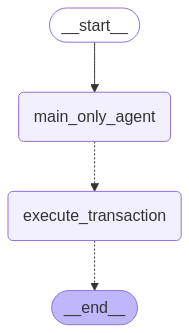

In [25]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
for s in graph.stream(
    {"messages": []}, subgraphs=True
):
    print(s)
    print("----")

/home/denis/miniconda3/envs/jb/lib/python3.13/site-packages/langchain_google_genai/chat_models.py:1410: UserWarning: ChatGoogleGenerativeAI.with_structured_output with dict schema has changed recently to align with behavior of other LangChain chat models. More context: https://github.com/langchain-ai/langchain-google/pull/772
  warnings.warn(


((), {'main_only_agent': {'messages': [HumanMessage(content='{"recieve_address": "0xD1dfB40454acb80203AEdB4db73f39A045FA8927", "amount": 1.0}', additional_kwargs={}, response_metadata={}, role='user')]}})
----
Connected to Ganache!
((), {'execute_transaction': {'messages': [HumanMessage(content="\n    Transaction executed successfully!\n    Transaction Hash: b'\\xae\\xaeR\\xe95a\\x93\\xb0Iv\\x1f\\xca\\xf2\\xe4\\x81;\\x99\\xbbew\\xbc\\x95b3\\xe8Pw8\\x18\\xb71\\x9a'\n    Transaction Receipt: AttributeDict({'transactionHash': HexBytes('0xaeae52e9356193b049761fcaf2e4813b99bb6577bc956233e850773818b7319a'), 'transactionIndex': 0, 'blockNumber': 4, 'blockHash': HexBytes('0x203df6329745ffa7962b8d095f4156ac00b54b74d444e34744c2e1bbbe17c4ef'), 'from': '0xa6491ebE45EEcfeeA6E695ed898aaD8d506011a6', 'to': '0xD1dfB40454acb80203AEdB4db73f39A045FA8927', 'cumulativeGasUsed': 21000, 'gasUsed': 21000, 'contractAddress': None, 'logs': [], 'logsBloom': HexBytes('0x0000000000000000000000000000000000000000000